In [1]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

from gensim import corpora
import string
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from gensim.models.coherencemodel import CoherenceModel
import csv

In [2]:
from nltk.tokenize import word_tokenize

### 1. Import Shangrila Data

In [3]:
df_shang_TA = pd.read_csv('C:/Users/n0rv1/Project/Tripadvisor/TAShangrilaworkClean.csv', sep = ',',encoding='cp1252')
#df_shang_TA = pd.read_csv('C:/Users/nchandra.CATLIN/Final Project/TAShangrilaworkClean.csv', sep = ',',encoding='cp1252')

In [4]:
df_shang_TA.head()

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate
0,One of the best!,The minute you are greeted by the staff outsid...,Jan-19,20-Jan-19,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0"
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,Jul-18,5-Aug-18,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0"
2,Fantastic stay,The hotel is stunning and has so much to offer...,Jan-19,20-Jan-19,NaN,5,couple,NaN
3,You’re simply the best!,"Arriving for a two days stop over, playing gol...",Jan-19,19-Jan-19,"Shanghai, China",5,solo,NaN
4,Vacation,Lovely pool with lush garden griunds and atten...,Jan-19,17-Jan-19,NaN,5,couple,NaN


In [5]:
df_shang_TA.shape

(4970, 8)

In [6]:
print(df_shang_TA.dtypes)

title          object
review         object
stay_date      object
review_date    object
origin         object
rate            int64
trip_type      object
detail_rate    object
dtype: object


In [7]:
# convert review_date and stay_date class to datetime
from datetime import datetime
df_shang_TA['review_date'] = pd.to_datetime(df_shang_TA['review_date'], format = '%d-%b-%y', errors = 'coerce')

In [8]:
df_shang_TA['stay_date'] = pd.to_datetime(df_shang_TA['stay_date'], format = '%b-%y', errors = 'coerce')
df_shang_TA['stay_year'] = pd.to_datetime(df_shang_TA['stay_date'], format='%b-%y').dt.year
#df_shang_TA['stay_date'] = (datetime.strptime(i, '%B-%y') for i in df_shang_TA['stay_date'] )

In [9]:
df_shang_TA.head()

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year
0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0
2,Fantastic stay,The hotel is stunning and has so much to offer...,2019-01-01,2019-01-20,NaN,5,couple,NaN,2019.0
3,You’re simply the best!,"Arriving for a two days stop over, playing gol...",2019-01-01,2019-01-19,"Shanghai, China",5,solo,NaN,2019.0
4,Vacation,Lovely pool with lush garden griunds and atten...,2019-01-01,2019-01-17,NaN,5,couple,NaN,2019.0


In [10]:
# find number of duplicates
df_shang_TA.duplicated(keep = 'first').sum()

439

In [11]:
# ratio of duplicates
print("%.2f%%" % (df_shang_TA.duplicated(keep = 'first').sum()/len(df_shang_TA)*100))

8.83%


In [12]:
# remove duplicate rows
df_shang_TA.drop_duplicates(keep = 'first', inplace = True)

In [13]:
df_shang_TA.shape

(4531, 9)

In [14]:
print('Earliest Review: ' + str(df_shang_TA['review_date'].min()))

Earliest Review: 2004-07-06 00:00:00


In [15]:
print('Latest Review: ' + str(df_shang_TA['review_date'].max()))

Latest Review: 2019-01-20 00:00:00


In [16]:
import datetime

In [17]:
df_shang_TA_week = df_shang_TA.groupby(pd.Grouper(key = 'review_date', freq = 'W')).count()

In [18]:
df_shang_TA_week.tail()

,title,review,stay_date,origin,rate,trip_type,detail_rate,stay_year
review_date,,,,,,,,
2018-12-23,9,9,9,7,9,9,3,9
2018-12-30,14,14,14,11,14,14,6,14
2019-01-06,11,11,11,8,11,11,6,11
2019-01-13,12,12,12,7,12,12,5,12
2019-01-20,12,12,12,10,12,12,4,12


In [19]:
df_shang_TA_week.sort_values(by = ['title'], ascending = False).head(10)

,title,review,stay_date,origin,rate,trip_type,detail_rate,stay_year
review_date,,,,,,,,
2016-01-10,28,28,28,24,28,23,15,28
2016-03-20,26,26,26,25,26,24,16,26
2014-08-17,23,23,23,23,23,17,15,23
2016-05-08,22,22,22,18,22,16,9,22
2016-02-28,22,22,22,21,22,17,12,22
2015-08-09,22,22,22,21,22,19,15,22
2016-05-22,21,21,21,19,21,15,7,21
2014-12-28,21,21,21,20,21,19,17,21
2016-02-14,21,21,21,17,21,15,12,21


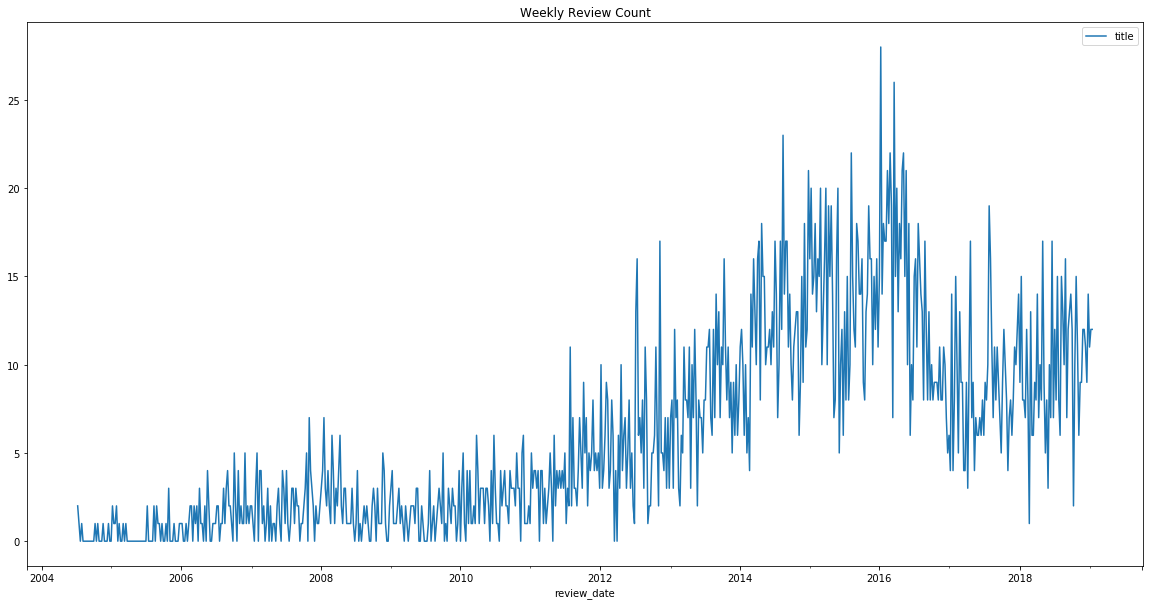

In [20]:
df_shang_TA_week.plot(y = 'title', figsize=(20,10), title = 'Weekly Review Count')
plt.show()

### 2. Text Preprocessing

In [21]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [22]:
# Convert all to lower case, remove punctuation
punc_free_review = df_shang_TA['review'].apply(lambda x: ''.join([ch for ch in x.lower() if ch not in exclude]))

In [23]:
# check if punctuation has been successfully removed
punc_free_review[1]

'the valley wing was absolutely fabulous from the moment we checked in you were treated liked a valued customer even though we hadnt been there before we had a deluxe room and it really was lovely king size bed huge bathroom with french toiletries and fluffy towels there was a fruit bowl which was checked and refilled everyday a nespresso machine and wedgwood china the room was kept spotless by our great housekeeper in the lobby lounge all the drinks and tea and coffee are complimentary we enjoyed a glass of french champagne after a hard day of sight seeingor maybe two the breakfast in the mornings in the summit room were delicious and you could not find fault with it even if you tried all in all one of the best experiences we have had and will certainly be going back again'

In [24]:
# Remove stopwords
stop_free_review = punc_free_review.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [25]:
# check if stopwords have been successfully removed
stop_free_review[1]

'valley wing absolutely fabulous moment checked treated liked valued customer even though hadnt deluxe room really lovely king size bed huge bathroom french toiletries fluffy towels fruit bowl checked refilled everyday nespresso machine wedgwood china room kept spotless great housekeeper lobby lounge drinks tea coffee complimentary enjoyed glass french champagne hard day sight seeingor maybe two breakfast mornings summit room delicious could find fault even tried one best experiences certainly going back'

In [26]:
# Lemmatize
lemma_review = stop_free_review.apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.split()]))

In [27]:
lemma_review[1]

'valley wing absolutely fabulous moment checked treated liked valued customer even though hadnt deluxe room really lovely king size bed huge bathroom french toiletry fluffy towel fruit bowl checked refilled everyday nespresso machine wedgwood china room kept spotless great housekeeper lobby lounge drink tea coffee complimentary enjoyed glass french champagne hard day sight seeingor maybe two breakfast morning summit room delicious could find fault even tried one best experience certainly going back'

In [28]:
# Stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

stem_review = lemma_review.apply(lambda x: ''.join([stemmer.stem(word) for word in x]))

In [29]:
type(stem_review)

pandas.core.series.Series

In [30]:
df_shang_TA['tokenized_review'] = stem_review

In [31]:
df_shang_TA['tokenized_review'][1]

'valley wing absolutely fabulous moment checked treated liked valued customer even though hadnt deluxe room really lovely king size bed huge bathroom french toiletry fluffy towel fruit bowl checked refilled everyday nespresso machine wedgwood china room kept spotless great housekeeper lobby lounge drink tea coffee complimentary enjoyed glass french champagne hard day sight seeingor maybe two breakfast morning summit room delicious could find fault even tried one best experience certainly going back'

### 3. Get a sense of the high frequency words

In [32]:
from wordcloud import WordCloud

In [33]:
all_words = ' '.join([text for text in df_shang_TA.tokenized_review])

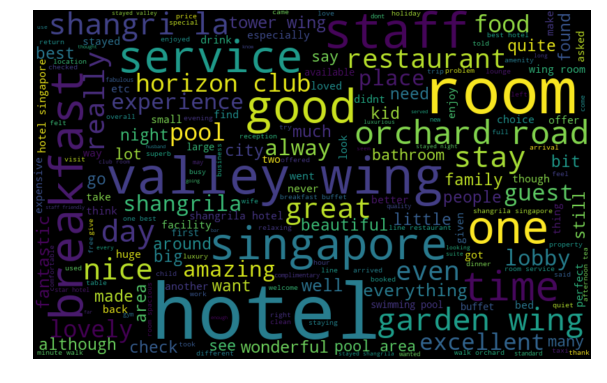

In [34]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Some of high frequency words such as "hotel" carries little meaning

In [35]:
bag_of_words = ' '.join(df_shang_TA.tokenized_review).split()

In [36]:
len(bag_of_words)

333614

In [37]:
wordfreqlist = nltk.FreqDist(bag_of_words)

In [38]:
mostcommon = wordfreqlist.most_common(50)

In [39]:
print(mostcommon)

[('hotel', 8322), ('room', 6777), ('staff', 3499), ('wing', 3224), ('service', 3180), ('singapore', 2768), ('stay', 2721), ('breakfast', 2669), ('pool', 2488), ('stayed', 2348), ('good', 2197), ('great', 2196), ('shangrila', 1962), ('garden', 1955), ('one', 1953), ('time', 1872), ('food', 1731), ('would', 1725), ('day', 1681), ('valley', 1612), ('restaurant', 1609), ('u', 1599), ('night', 1524), ('also', 1475), ('well', 1450), ('area', 1434), ('orchard', 1391), ('nice', 1351), ('excellent', 1333), ('like', 1252), ('really', 1224), ('club', 1179), ('best', 1103), ('road', 1081), ('get', 1045), ('buffet', 1022), ('back', 1015), ('la', 978), ('lovely', 915), ('place', 907), ('friendly', 900), ('could', 896), ('experience', 896), ('beautiful', 884), ('shangri', 881), ('much', 859), ('line', 853), ('walk', 851), ('even', 845), ('amazing', 835)]


Proceed to remove the following words: hotel, singapore, shangrila, would, u

In [40]:
domain_stop = ['hotel', 'shangri', 'shangrila', 'would', 'singapore', 'u', 'la', 'could', 'room']

In [41]:
stop.update(domain_stop)

In [42]:
# Remove stopwords
stem_review2 = stem_review.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [43]:
df_shang_TA['tokenized_review'] = stem_review2

In [44]:
all_words2 = ' '.join([text for text in df_shang_TA['tokenized_review']])

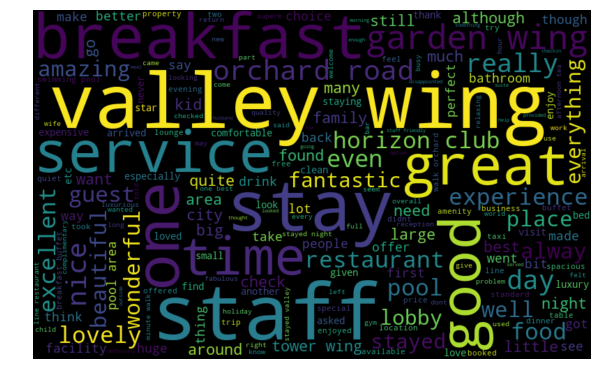

In [45]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [46]:
bag_of_words2 = ' '.join(df_shang_TA.tokenized_review).split()

In [47]:
wordfreqlist2 = nltk.FreqDist(bag_of_words2)

In [48]:
mostcommon2 = wordfreqlist2.most_common(30)
print(mostcommon2)

[('staff', 3499), ('wing', 3224), ('service', 3180), ('stay', 2721), ('breakfast', 2669), ('pool', 2488), ('stayed', 2348), ('good', 2197), ('great', 2196), ('garden', 1955), ('one', 1953), ('time', 1872), ('food', 1731), ('day', 1681), ('valley', 1612), ('restaurant', 1609), ('night', 1524), ('also', 1475), ('well', 1450), ('area', 1434), ('orchard', 1391), ('nice', 1351), ('excellent', 1333), ('like', 1252), ('really', 1224), ('club', 1179), ('best', 1103), ('road', 1081), ('get', 1045), ('buffet', 1022)]


In [49]:
df_shang_TA.head()

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review
0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,minute greeted staff outside quite uniform esc...
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...
2,Fantastic stay,The hotel is stunning and has so much to offer...,2019-01-01,2019-01-20,NaN,5,couple,NaN,2019.0,stunning much offer couple family gym especial...
3,You’re simply the best!,"Arriving for a two days stop over, playing gol...",2019-01-01,2019-01-19,"Shanghai, China",5,solo,NaN,2019.0,arriving two day stop playing golf unfortunate...
4,Vacation,Lovely pool with lush garden griunds and atten...,2019-01-01,2019-01-17,NaN,5,couple,NaN,2019.0,lovely pool lush garden griunds attentive staf...


In [50]:
df_shang_TA['rate'].unique()

array([5, 4, 2, 3, 1], dtype=int64)

In [51]:
# if the rate is above 3 classify as 1, 3 as 0, below 3 as -1

In [52]:
df_shang_TA = df_shang_TA.assign(rate_cat = lambda v: v.rate.apply(lambda x: -1 if x < 3 else 1 if x > 3 else 0))

In [53]:
df_shang_TA.head()

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat
0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,minute greeted staff outside quite uniform esc...,1
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1
2,Fantastic stay,The hotel is stunning and has so much to offer...,2019-01-01,2019-01-20,NaN,5,couple,NaN,2019.0,stunning much offer couple family gym especial...,1
3,You’re simply the best!,"Arriving for a two days stop over, playing gol...",2019-01-01,2019-01-19,"Shanghai, China",5,solo,NaN,2019.0,arriving two day stop playing golf unfortunate...,1
4,Vacation,Lovely pool with lush garden griunds and atten...,2019-01-01,2019-01-17,NaN,5,couple,NaN,2019.0,lovely pool lush garden griunds attentive staf...,1


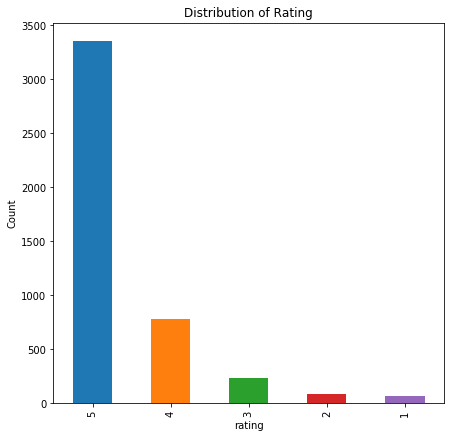

In [54]:
df_shang_TA['rate'].value_counts().plot(kind = 'bar', figsize = (7,7), title = "Distribution of Rating")
plt.xlabel('rating')
plt.ylabel('Count')
plt.show()

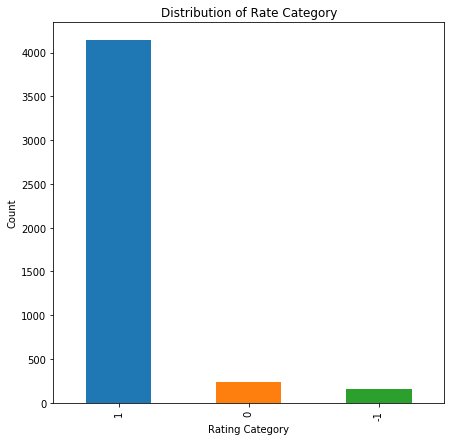

In [55]:
df_shang_TA['rate_cat'].value_counts().plot(kind = 'bar', figsize=(7,7), title = 'Distribution of Rate Category')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()

Very imbalanced data

### 3.2 Read in Fullerton Data

In [59]:
#df_fl_TA = pd.read_csv('C:/Users/nchandra.CATLIN/Final Project/TAFullerton.csv', sep = ',',encoding='cp1252')
df_fl_TA = pd.read_csv('C:/Users/n0rv1/Project/Tripadvisor/TAFullerton.csv', sep = ',',encoding='cp1252')

In [60]:
df_fl_TA.head()

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate
0,Just as stunning in person..,Loved learning a bit of history behind this ho...,Jan-19,27-Jan-19,"Frisco, Texas",5,couple,NaN
1,Fabulous historic building overlooking Singapo...,The hotel is housed in an old colonial buildin...,Dec-18,26-Jan-19,"London, United Kingdom",5,family,NaN
2,A Great hotel with all the amenities,We stayed in the Fullerton Hotel for 4 nights ...,Jan-19,26-Jan-19,"Southwell, United Kingdom",4,couple,NaN
3,We love this hotel BUT,We have stayed in this lovely hotel several ti...,Jan-19,25-Jan-19,"London, United Kingdom",5,couple,NaN
4,Great hotel. But gave away our adjoining room....,Asked for connecting or adjoining rooms for fa...,Jan-19,24-Jan-19,NaN,2,family,NaN


In [61]:
len(df_fl_TA)

2076

In [62]:
df_fl_TA['stay_date'] = pd.to_datetime(df_fl_TA['stay_date'], format = '%b-%y', errors = 'coerce')
df_fl_TA['stay_year'] = pd.to_datetime(df_fl_TA['stay_date'], format = '%b-%y').dt.year

In [63]:
df_fl_TA['review_date'] = pd.to_datetime(df_fl_TA['review_date'], format = '%d-%b-%y', errors = 'coerce')

In [64]:
# Convert all to lower case, remove punctuation
punc_free_review = df_fl_TA['review'].apply(lambda x: ''.join([ch for ch in x.lower() if ch not in exclude]))
# Remove Stop words
stop_free_review = punc_free_review.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
# Lemmatize
lemma_review = stop_free_review.apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.split()]))
# Stemming
stem_review = lemma_review.apply(lambda x: ''.join([stemmer.stem(word) for word in x]))

In [65]:
df_fl_TA['tokenized_review'] = stem_review

In [66]:
df_fl_TA.head(1)

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review
0,Just as stunning in person..,Loved learning a bit of history behind this ho...,2019-01-01,2019-01-27,"Frisco, Texas",5,couple,NaN,2019.0,loved learning bit history behind formally pos...


In [67]:
df_fl_TA = df_fl_TA.assign(rate_cat = lambda v: v.rate.apply(lambda x: -1 if x < 3 else 1 if x > 3 else 0))

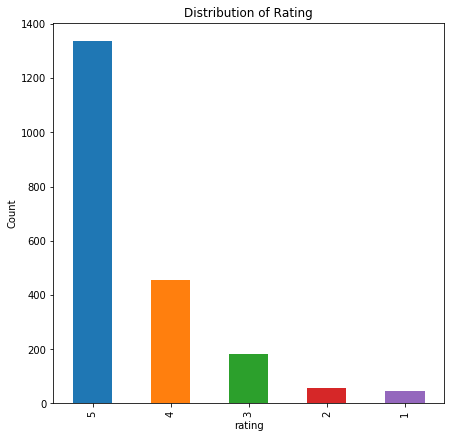

In [68]:
df_fl_TA['rate'].value_counts().plot(kind = 'bar', figsize = (7,7), title = "Distribution of Rating")
plt.xlabel('rating')
plt.ylabel('Count')
plt.show()

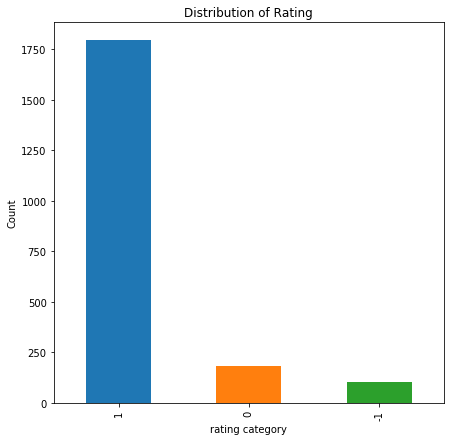

In [69]:
df_fl_TA['rate_cat'].value_counts().plot(kind = 'bar', figsize = (7,7), title = "Distribution of Rating")
plt.xlabel('rating category')
plt.ylabel('Count')
plt.show()

### 4. Getting Sentiment on Focus Area

In [70]:
# focus area: room, breakfast, housekeeping
amenities = {
    'wifi':      ['wifi','internet','wi-fi', 'wi fi', 'wireless', 'wifi-', 'wlan', 'connectivity'],
    'breakfast': ['breakfast', 'breakfest', 'break fast', 'brunch', 'food', 'restaurant'],
    'bathroom':  ['bathroom', 'bath room', 'bath', 'restroom', 'toilet', 
                  'urinal', 'lavatory', 'washroom'],
    'shower':    ['shower', 'bathe', 'showers'],
    'location' : ['convenient', 'far', 'taxi', 'secluded'],
    'noise':     ['noise', 'noisy', 'quiet', 'loud', 'silent'],
    'bed': ['bed', 'mattress', 'pillow', 'bolster', 'duvet', 'blanket', 'bedsheet', 'sheet'],
    'housekeeping': ['housekeeping', 'housekeep', 'room','bedroom', 'clean', 'tidy', 'hair', 'spot', 
                    'dirty', 'linen', 'sheet', 'curtain', 'desk', 'wet', 'mold',
                    'damp']
}

In [71]:
import re
from textblob import TextBlob
from nltk import sent_tokenize

In [72]:
##### Trial code to see if sub code works ######
# df_shang_TA['review'][202].split('.', maxsplit = 0)

In [73]:
# sentence = sent_tokenize(df_shang_TA['review'][202])

In [74]:
#for sent in sentence:
    #print(sent.split())

In [75]:
#for sent in sentence:
    #for word in sent.split():
        #if word not in exclude and word in amenities['wifi']:
            #print(sent.lower().strip())

In [76]:
##################################################

In [77]:
def get_key_sentence(x, key_list):
    sentences = sent_tokenize(x)
    for sent in sentences:
        for word in sent.split():
            if word.lower() in key_list:
                return sent

In [78]:
def parse_reviews(subset, key):
    """ Takes in a dataframe and key
        Returns a dictionary with the highest frequency words and their counts
        where the key was found in the reviews
    """
    word_freq = {}
    #stopwords = nltk.corpus.stopwords.words('english')
    for i in range(0, len(subset)): #loop through each review
        count_words(word_freq, subset[key][i], stop, amenities[key])    
    return word_freq

In [79]:
def count_words(word_freq, sent, stopwords, list_key):
    """Takes in a dictionary, sentence or phrase, stopwords, and bag of words
       and appends counts for word frequencies not in stopwords to find
       the most common words in the reviews
    """
    for word in sent.split():
        word = word.lower()
        word = ''.join( ch for ch in word if  ch not in exclude )
        word = lemma.lemmatize(word)
        if word not in stop and word not in list_key and len(word) > 3:
            if word not in word_freq:
                word_freq[word] = 1
            else:
                word_freq[word] += 1

In [80]:
df_shang_TA.head()

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat
0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,minute greeted staff outside quite uniform esc...,1
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1
2,Fantastic stay,The hotel is stunning and has so much to offer...,2019-01-01,2019-01-20,NaN,5,couple,NaN,2019.0,stunning much offer couple family gym especial...,1
3,You’re simply the best!,"Arriving for a two days stop over, playing gol...",2019-01-01,2019-01-19,"Shanghai, China",5,solo,NaN,2019.0,arriving two day stop playing golf unfortunate...,1
4,Vacation,Lovely pool with lush garden griunds and atten...,2019-01-01,2019-01-17,NaN,5,couple,NaN,2019.0,lovely pool lush garden griunds attentive staf...,1


#### 4.1a. WIFI Sentiment - Shangrila

In [81]:
# Work on wifi sentiment
df_shang_TA2 = df_shang_TA.copy()
df_fl_TA2 = df_fl_TA.copy()

In [82]:
df_shang_TA2.head(2)

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat
0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,minute greeted staff outside quite uniform esc...,1
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1


In [83]:
# get sentences that contain keywords under wifi category
# for Shangrila
df_shang_TA2['wifi'] = df_shang_TA2.apply(lambda x: get_key_sentence(x['review'], amenities['wifi']), axis = 1)
# for Grand Hyatt
df_fl_TA2['wifi'] = df_fl_TA2.apply(lambda x: get_key_sentence(x['review'], amenities['wifi']), axis = 1)

In [84]:
df_shang_TA2[df_shang_TA2['wifi'].notna()]

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat,wifi
45,Did a 3D 2N staycation with my 4-year old,We had a great experience at Shangri La Rasa S...,2018-12-01,2018-12-28,NaN,5,family,"Value, 5.0, Location, 5.0, Service, 5.0",2018.0,great experience rasa sentosa thought give one...,1,My son was calling Jana his favourite jie'jie ...
144,"Tranquility & relax, despite busy surrounding",Friendly staff who are ever ready to greet you...,2018-09-01,2018-10-28,"Singapore, Singapore",5,family,NaN,2018.0,friendly staff ever ready greet start moment s...,1,The Tower Wing deluxe room was expectedly clea...
202,A luxurious birthday staycation,Thank you to hotel staffs for making the effor...,2018-08-01,2018-09-21,"Singapore, Singapore",4,couple,"Location, 5.0, Sleep Quality, 5.0, Service, 4.0",2018.0,thank staff making effort set cute decoration ...,1,"Pros:- Very spacious, comfortable and luxuriou..."
220,Great business hotel,"As a place for a work trip, this place is exce...",2018-08-01,2018-09-11,"Bali, Indonesia",4,business,"Value, 4.0, Sleep Quality, 5.0, Service, 5.0",2018.0,place work trip place excellent easy checkin q...,1,And there is free wifi everywhere!!!
466,Great oasis a short walk to Orchard Road.,Stayed recently for work and having stayed in ...,2018-04-01,2018-04-02,"Sydney, Australia",5,business,NaN,2018.0,stayed recently work stayed new favouritebig p...,1,Pretty good wifi as well.Breakfast has an amaz...
482,Excellence on every level,"Have visited numerous times through work, but ...",2018-03-01,2018-03-25,"London, United Kingdom",5,couple,"Location, 5.0, Rooms, 5.0, Service, 5.0",2018.0,visited numerous time work stayed mr extra day...,1,"The rooms are well presented and clean, with g..."
493,worth it,the hotel is expensive but i can say that its ...,2017-08-01,2018-03-16,South Korea,4,couple,"Value, 4.0, Rooms, 4.0, Service, 4.0",2017.0,expensive say worth well repainted good ac exc...,1,good AC and excellent wifi connection.
549,Singapore stop over,We always like stopping over in singapore for ...,2018-01-01,2018-01-29,"Queenstown, New Zealand",4,family,NaN,2018.0,always like stopping day way home new zealand ...,1,The only problem we had was the internet in ou...
562,A resort experience close to Orchard Rd,We initially booked connecting rooms in the to...,2018-01-01,2018-01-20,"Richmond, Victoria, Australia",5,family,"Location, 5.0, Sleep Quality, 5.0, Service, 5.0",2018.0,initially booked connecting tower based intern...,1,We initially booked connecting rooms in the to...
717,A memorable & a wonderful stay !!,We stayed at Shangri La hotel on my visit to S...,2017-10-01,2017-10-06,"Bengaluru, India",5,couple,NaN,2017.0,stayed visit booked valley wing three wing nam...,1,"They have a big swimming pool, a small water f..."


In [85]:
df_fl_TA2[df_fl_TA2['wifi'].notna()]

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat,wifi
8,Premium Stay fora 5 Star Hotel,"Room was very clean, bed comfy, large space fo...",2018-11-01,2019-01-22,"Singapore, Singapore",5,family,NaN,2018.0,clean bed comfy large space daughter run aroun...,1,"Bathtub available, minibar full, tv and wifi i..."
10,Club lounge room ??,"Club Lounge ,3 Night stay and I am Very happy ...",2019-01-01,2019-01-21,"Perth, Western Australia, Australia",5,family,NaN,2019.0,club lounge 3 night stay happy booked one club...,1,Wifi wasnt the fastest but was adequate and co...
28,Excellent hotel with great amenities,I had a perfect two night stay in this hotel l...,2018-12-01,2019-01-05,"Jakarta, Indonesia",5,couple,NaN,2018.0,perfect two night stay last december though ch...,1,Love that they have wireless speaker in the room.
121,"Search no more, you REALLY should stay here.",You really want to be on this side of the bay ...,2018-08-01,2018-09-24,San Francisco Bay Area,5,couple,NaN,2018.0,really want side bay looking toward marina bay...,1,They provide a phone sized computer called the...
161,Frankly First Class (Forgive the post office p...,This was our second stay at the Fullerton in S...,2018-07-01,2018-07-28,"Colchester, United Kingdom",5,couple,NaN,2018.0,second stay fullerton first stay prior joining...,1,WIFi was quick and free.The lounge experience ...
190,Colonial Singapore,We stayed here for 2 nights following a night ...,2018-07-01,2018-07-09,"Wales, United Kingdom",5,couple,NaN,2018.0,stayed 2 night following night marina bay sand...,1,We fell in love with the pool area which provi...
203,Lunch appointment that never materialize,I had a lunch appointment at Fullerton Hotel o...,2018-06-01,2018-06-29,NaN,1,couple,NaN,2018.0,lunch appointment fullerton 29th june got car ...,-1,"Right after he went in, I noticed that my husb..."
218,The hotel makes things difficult for no good r...,My hotel room faced other rooms/corridor. So I...,2018-06-01,2018-06-14,"New Delhi, India",3,business,NaN,2018.0,faced roomscorridor keep curtain drawn timeit ...,0,It took 2-3 days to get used to the system Why...
252,A great comfortable place to stay in,"at the waterfront, and walkable distance to me...",2017-10-01,2018-05-03,Wisconsin,5,couple,NaN,2017.0,waterfront walkable distance merlion fantastic...,1,"The in room amenities has a special addition, ..."
349,The best hotel!,I stayed in the Courtyard which is 42m sq. The...,2017-12-01,2017-12-28,"Singapore, Singapore",5,business,NaN,2017.0,stayed courtyard 42m sq large many latest gadg...,1,The room is large with many latest gadgets pla...


In [86]:
df_shang_TA2['wifi'].notna().sum()

201

In [87]:
df_fl_TA2['wifi'].notna().sum()

89

In [88]:
# drop those reviews that do not talk about wifi
subset_wifi_shang = df_shang_TA2.dropna(subset = ['wifi'])
subset_wifi_fl = df_fl_TA2.dropna(subset = ['wifi'])

In [89]:
subset_wifi_shang.reset_index(inplace = True)
subset_wifi_fl.reset_index(inplace = True)

In [90]:
print(len(subset_wifi_shang))
print(len(subset_wifi_fl))

201
89


In [91]:
# use TextBlob to get the sentiment polarity
subset_wifi_shang['sentiment'] = subset_wifi_shang['wifi'].apply(lambda x: TextBlob(x).sentiment.polarity)
subset_wifi_fl['sentiment'] = subset_wifi_fl['wifi'].apply(lambda x: TextBlob(x).sentiment.polarity)

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
# get the word frequency from reviews on wifi
word_freq_wifi_shang = parse_reviews(subset_wifi_shang, 'wifi')
word_freq_wifi_fl = parse_reviews(subset_wifi_fl, 'wifi')

In [93]:
word_freq_wifi_shang

{'calling': 1,
 'jana': 1,
 'favourite': 2,
 'jiejie': 1,
 'elder': 1,
 'sister': 1,
 'think': 1,
 'love': 2,
 'herthe': 1,
 'news': 1,
 'movie': 2,
 'channel': 1,
 'selection': 4,
 'wide': 2,
 'reception': 3,
 'great': 23,
 'everywhere': 6,
 'tower': 4,
 'wing': 13,
 'deluxe': 3,
 'expectedly': 1,
 'clean': 9,
 'well': 23,
 'provided': 5,
 'stationery': 1,
 'easy': 5,
 'connection': 19,
 'though': 6,
 'kingsize': 1,
 'tends': 1,
 'make': 5,
 'squeezing': 1,
 'spacious': 11,
 'comfortable': 8,
 'luxurious': 4,
 'best': 9,
 'study': 1,
 'area': 19,
 'design': 1,
 'good': 41,
 'shower': 10,
 'bathtub': 1,
 'toilet': 4,
 'amenity': 3,
 'location': 8,
 'close': 4,
 'city': 5,
 'friendly': 9,
 'staff': 24,
 'thank': 1,
 'complimentary': 15,
 'birthday': 1,
 'cake': 5,
 'decoration': 1,
 'quiet': 3,
 'roompros': 1,
 'reached': 1,
 'surprised': 2,
 'find': 6,
 'locked': 1,
 'free': 87,
 'pretty': 2,
 'wellbreakfast': 1,
 'amazing': 5,
 'range': 2,
 'option': 3,
 'type': 1,
 'cuisine': 1,
 'qu

In [94]:
word_freq_wifi_fl

{'bathtub': 4,
 'available': 7,
 'minibar': 3,
 'full': 1,
 'good': 26,
 'wasnt': 1,
 'fastest': 1,
 'adequate': 1,
 'stream': 1,
 'online': 1,
 'video': 1,
 'issue': 3,
 'love': 2,
 'speaker': 2,
 'provide': 5,
 'phone': 8,
 'sized': 3,
 'computer': 1,
 'called': 2,
 'handy': 3,
 'help': 3,
 'find': 5,
 'around': 6,
 'town': 1,
 'extremely': 4,
 'helpful': 5,
 'quick': 2,
 'freethe': 2,
 'lounge': 1,
 'experience': 3,
 'anywhere': 2,
 'world': 1,
 'fell': 1,
 'pool': 6,
 'area': 5,
 'provided': 7,
 'welcoming': 1,
 'relief': 1,
 'exploring': 2,
 'cityit': 1,
 'worth': 4,
 'mentioning': 1,
 '“handy”': 1,
 'mobile': 8,
 'device': 3,
 'take': 4,
 'godsend': 1,
 'don’t': 1,
 'access': 11,
 'data': 1,
 'outside': 2,
 'right': 1,
 'went': 3,
 'noticed': 1,
 'husband': 1,
 'call': 5,
 'return': 1,
 'stop': 1,
 'middle': 1,
 'road': 1,
 'without': 1,
 'took': 2,
 'used': 4,
 'system': 1,
 'cant': 1,
 'keep': 2,
 'thing': 3,
 'simplehotel': 1,
 'offer': 2,
 'free': 34,
 'disconnect': 1,
 'ever

In [95]:
from collections import Counter
d_shang = Counter(word_freq_wifi_shang)
d_fl = Counter(word_freq_wifi_fl)
phrase_words_shang = [x[0] for x in d_shang.most_common(5)] #find top 5 keywords describing each review
phrase_words_fl = [x[0] for x in d_fl.most_common(5)]

In [96]:
# highest frequency words from review about wifi
print('Highest Frequency words about wifi in Shangrila: ')
print(phrase_words_shang)

Highest Frequency words about wifi in Shangrila: 
['free', 'good', 'breakfast', 'access', 'service']


In [97]:
print('Highest Frequency words about wifi in Fullerton: ')
print(phrase_words_fl)

Highest Frequency words about wifi in Fullerton: 
['free', 'good', 'also', 'access', 'breakfast']


In [98]:
# Review Sentiments for Shangrila
print('Wifi Review Sentiments for Shangrila')
print('Positive Review: ' + str(len(subset_wifi_shang[subset_wifi_shang['sentiment'] >0])))
print('Negative Review: ' + str(len(subset_wifi_shang[subset_wifi_shang['sentiment'] < 0])))
print('Neutral Review: ' + str(len(subset_wifi_shang[subset_wifi_shang['sentiment'] == 0])))

Wifi Review Sentiments for Shangrila
Positive Review: 168
Negative Review: 17
Neutral Review: 16


In [99]:
# Review Sentiments for Fullerton
print('Wifi Review sentiments for Fullerton')
print('Positive Review: ' + str(len(subset_wifi_fl[subset_wifi_fl['sentiment'] >0])))
print('Negative Review: ' + str(len(subset_wifi_fl[subset_wifi_fl['sentiment'] < 0])))
print('Neutral Review: ' + str(len(subset_wifi_fl[subset_wifi_fl['sentiment'] == 0])))

Wifi Review sentiments for Fullerton
Positive Review: 72
Negative Review: 8
Neutral Review: 9


In [100]:
print('3 lowest sentiment review for Shangrila - WIFI:')
print('')
for z in subset_wifi_shang.nsmallest(3, 'sentiment')['wifi']:
    print(z)
    print('')

3 lowest sentiment review for Shangrila - WIFI:

Sadly, the WiFi is not secured!

Even though a Horizon Club room may seem expensive, remember that breakfast at The Line or The Horizon Club is included and so is Wifi and the use of the conference rooms.

If u wan relaxation, u can consider here.However, u might b disappointed with the Wi-Fi network here.



In [101]:
print('3 lowest sentiment review for Fullerton - WIFI:')
print('')
for z in subset_wifi_fl.nsmallest(3, 'sentiment')['wifi']:
    print(z)
    print('')

3 lowest sentiment review for Fullerton - WIFI:

The internet was idiotically expensive- $30 SGD a night.

28 dollars for wired only internet use for 24 hours also struck me as outrageous, and we complained about this in person and in writing.

We wanted to try to Fullerton Hotel as it seemed ok from the outside but we discovered that it is just ugly and cold, dirty and with bad wifi on the inside.



In [102]:
print('3 best sentiment review for Shangrila - WIFI:')
print('')
for x in subset_wifi_shang.nlargest(3, 'sentiment')['wifi']:
    print(x)
    print('')

3 best sentiment review for Shangrila - WIFI:

Electric curtains, air con and a LAN provided internet service made the Shangri La probably one of the best hotels I have stayed in.

good AC and excellent wifi connection.

The Wifi is great - you can have have connection while sipping your cappucino at the pool area.



In [103]:
print('3 best sentiment review for Fullerton - WIFI:')
print('')
for x in subset_wifi_fl.nlargest(3, 'sentiment')['wifi']:
    print(x)
    print('')

3 best sentiment review for Fullerton - WIFI:

I searched the Internet and found an excellent place in Chinatown for S$120 - Physioclinic, 68 Tras Street.

We prepaid a discounted internet rate on their website which was a great saving.

The room was well appointed, with excellent wifi and a spacious, rather grand bathroom.



In [104]:
#subset_wifi_shang['stay_year'] = subset_wifi_shang.stay_date.apply(lambda x: x.strftime('%y'))
#subset_wifi_fl['stay_year'] = subset_wifi_fl.stay_date.apply(lambda x: x.strftime('%y'))

In [105]:
#subset_wifi_shang.head()

In [106]:
# Average sentiment polarity grouped by year
mean_wifi_shang = subset_wifi_shang.groupby('stay_year').mean().reset_index()
mean_wifi_fl = subset_wifi_fl.groupby('stay_year').mean().reset_index()

In [107]:
mean_wifi_shang.dtypes

stay_year    float64
index        float64
rate         float64
rate_cat     float64
sentiment    float64
dtype: object

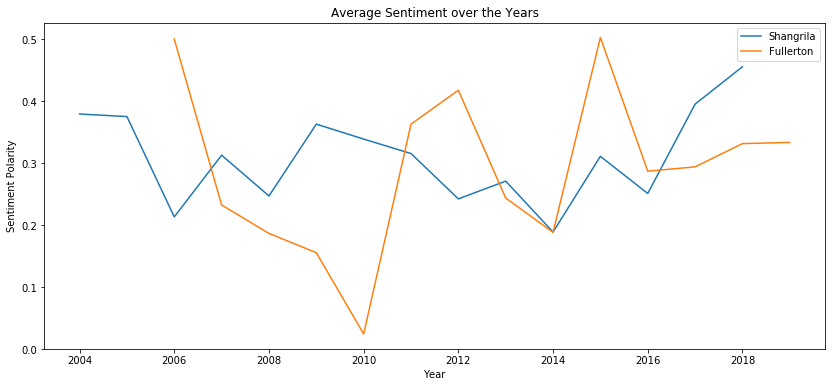

In [108]:
fig = plt.figure(figsize = (14,6))

for frame in [mean_wifi_shang, mean_wifi_fl]:
    plt.plot(frame['stay_year'], frame['sentiment'])
    
plt.legend(['Shangrila', 'Fullerton'])
plt.title('Average Sentiment over the Years')
plt.xlabel('Year')
plt.ylabel('Sentiment Polarity')
plt.show()

In [109]:
#x = mean_wifi_fl['stay_year']
#y = mean_wifi_shang['sentiment']
#z = mean_wifi_fl['sentiment']
#plt.figure(figsize = (14,5))
#plt.plot(x,z)
#plt.xticks(x)
#plt.title('Average Sentiment over the Years')
#plt.xlabel('Year')
#plt.ylabel('Sentiment Polarity')
#plt.show()

Guests' sentiment on wifi has improved

#### 4.2. Get Breakfast Sentiment

In [110]:
# work on breakfast sentiment
df_shang_TA3 = df_shang_TA.copy()
df_fl_TA3 = df_fl_TA.copy()

In [111]:
df_shang_TA3['breakfast'] = df_shang_TA3.apply(lambda x: get_key_sentence(x['review'], amenities['breakfast']), axis = 1)
df_fl_TA3['breakfast'] = df_fl_TA3.apply(lambda x: get_key_sentence(x['review'], amenities['breakfast']), axis = 1)

In [112]:
df_shang_TA3['breakfast'].notna().sum()

2504

In [113]:
subset_breakfast_shang = df_shang_TA3.dropna(subset = ['breakfast'])
subset_breakfast_fl = df_fl_TA3.dropna(subset = ['breakfast'])

In [114]:
subset_breakfast_shang.head(5)

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat,breakfast
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1,The breakfast in the mornings in the Summit ro...
7,Family stay in the Treetop Family Suite,We just had a fantastic two night stay in the ...,2019-01-01,2019-01-17,"Singapore River, Singapore",5,family,NaN,2019.0,fantastic two night stay treetop family themed...,1,We could either have breakfast in the Horizon ...
8,Exactly what you'd expect from a Shangri-La,Definitely one of my favourite brands and the ...,2019-01-01,2019-01-16,"Vancouver, Canada",5,couple,"Value, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,definitely one favourite brand original starte...,1,"In fact, we were even advised by friends to tr..."
9,Absolute excellence in every respect,The foyer was bedecked with stunning Christmas...,2018-12-01,2019-01-16,"Brisbane, Australia",5,solo,"Location, 5.0, Rooms, 5.0, Service, 5.0",2018.0,foyer bedecked stunning christmas decoration s...,1,The foyer was bedecked with stunning Christmas...
11,Simply Perfect,"By far one of the best hotels we’ve stayed in,...",2018-12-01,2019-01-15,"Sydney, Australia",5,family,NaN,2018.0,far one best we’ve stayed booked deluxe family...,1,We had buffet breakfast at The Line restaurant...


In [115]:
len(subset_breakfast_shang)

2504

In [116]:
subset_breakfast_shang.reset_index(inplace = True)
subset_breakfast_fl.reset_index(inplace = True)

In [117]:
subset_breakfast_shang['sentiment'] = subset_breakfast_shang['breakfast'].apply(lambda x: TextBlob(x).sentiment.polarity)
subset_breakfast_fl['sentiment'] = subset_breakfast_fl['breakfast'].apply(lambda x: TextBlob(x).sentiment.polarity)

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [118]:
word_freq_breakfast_shang = parse_reviews(subset_breakfast_shang, 'breakfast')
word_freq_breakfast_fl = parse_reviews(subset_breakfast_fl, 'breakfast')

In [119]:
word_freq_breakfast_shang

{'morning': 111,
 'summit': 100,
 'delicious': 74,
 'find': 38,
 'fault': 15,
 'even': 77,
 'tried': 23,
 'either': 32,
 'horizon': 120,
 'club': 178,
 'line': 418,
 'fact': 12,
 'advised': 3,
 'friend': 8,
 'hawker': 7,
 'lobby': 70,
 'lounge': 96,
 'curated': 1,
 'local': 25,
 'foyer': 9,
 'bedecked': 1,
 'stunning': 15,
 'christmas': 11,
 'decoration': 6,
 'superb': 69,
 'every': 105,
 'firstclass': 1,
 'buffet': 536,
 'served': 92,
 'rich': 2,
 'selection': 102,
 'beautifully': 15,
 'cooked': 29,
 'choice': 203,
 'around': 66,
 'world': 63,
 'service': 462,
 'fast': 8,
 'attentive': 34,
 'personal': 21,
 'simply': 20,
 'quick': 8,
 'staff': 394,
 'ever': 105,
 'courteous': 17,
 'prepared': 18,
 'event': 8,
 'smacking': 1,
 'accommodation': 7,
 'newlyrenovated': 1,
 'tower': 59,
 'wing': 279,
 'outstanding': 34,
 'andreas': 2,
 'chan': 2,
 'guest': 60,
 'officer': 1,
 'team': 15,
 'located': 20,
 '24th': 29,
 'floor': 95,
 'afternoon': 63,
 'happy': 20,
 'hour': 48,
 'granted': 1,
 

In [120]:
from collections import Counter
d_shang = Counter(word_freq_breakfast_shang)
phrase_words_shang = [x[0] for x in d_shang.most_common(5)] #find top 3 keywords describing each review

In [121]:
print('Highest Frequency Words in review concerning breakfast')
print(phrase_words_shang)

Highest Frequency Words in review concerning breakfast
['buffet', 'service', 'good', 'line', 'staff']


In [122]:
# Shangrila review sentiment count
print('Shangrila Breakfast Sentiment')
print('Positive review: ' + str(len(subset_breakfast_shang[subset_breakfast_shang['sentiment'] > 0])))
print('Negative review: ' + str(len(subset_breakfast_shang[subset_breakfast_shang['sentiment'] < 0])))
print('Neutral review: ' + str(len(subset_breakfast_shang[subset_breakfast_shang['sentiment'] == 0])))

Shangrila Breakfast Sentiment
Positive review: 2095
Negative review: 174
Neutral review: 235


In [123]:
# positive review
print('Fullerton Breakfast Sentiment')
print('Positive review: ' + str(len(subset_breakfast_fl[subset_breakfast_fl['sentiment'] > 0])))
print('Negative review: ' + str(len(subset_breakfast_fl[subset_breakfast_fl['sentiment'] < 0])))
print('Neutral review: ' + str(len(subset_breakfast_fl[subset_breakfast_fl['sentiment'] == 0])))

Fullerton Breakfast Sentiment
Positive review: 858
Negative review: 80
Neutral review: 116


In [124]:
subset_breakfast_shang.loc[subset_breakfast_shang['sentiment'].idxmin()]['breakfast']

'The gym is well appointed and the breakfast is outrageous as is the lunch buffet.'

In [125]:
print('3 lowest sentiment review for Shangrila - Breakfast:')
print('')
for z in subset_breakfast_shang.nsmallest(3, 'sentiment')['breakfast']:
    print(z)
    print('')

3 lowest sentiment review for Shangrila - Breakfast:

The gym is well appointed and the breakfast is outrageous as is the lunch buffet.

I met another guest from the UK at breakfast and she was also commenting about how cold her room was and how terrible the duvet was.

We had breakfast in the Waterfall restaurant and were a bit disappointed by the choice.



In [126]:
print('3 highest sentiment review for Shangrila - Breakfast:')
print('')
for y in subset_breakfast_shang.nlargest(3, 'sentiment')['breakfast']:
    print(y)
    print('')

3 highest sentiment review for Shangrila - Breakfast:

The breakfast in the mornings in the Summit room were delicious and you could not find fault with it even if you tried!

Staff go out of their way to look after you buffet breakfast is magnificent.

The included breakfast was excellent and the range of food impressive.



In [127]:
subset_breakfast_shang.loc[subset_breakfast_shang['sentiment'].idxmax()]['breakfast']

'The breakfast in the mornings in the Summit room were delicious and you could not find fault with it even if you tried!'

In [128]:
print('3 lowest sentiment review for Fullerton - Breakfast:')
print('')
for z in subset_breakfast_fl.nsmallest(3, 'sentiment')['breakfast']:
    print(z)
    print('')

3 lowest sentiment review for Fullerton - Breakfast:

We had breakfast in the hotel one morning, but were disappointed and decided to dine out for the rest of the stay.

They continued the bad behavior in the Town Restaurant at breakfast.

Breakfast was a bit disappointing.



In [129]:
print('3 highest sentiment review for Fullerton - Breakfast:')
print('')
for y in subset_breakfast_fl.nlargest(3, 'sentiment')['breakfast']:
    print(y)
    print('')

3 highest sentiment review for Fullerton - Breakfast:

The food is excellent.

Best breakfast ever.

Our reservation included buffet breakfast which was wonderful.



In [130]:
subset_breakfast_shang['breakfast'][subset_breakfast_shang['sentiment'] < 0]

9       Hotel slightly let down by failure to allow la...
25      Now it only has one side open and the other si...
31      Price per room is inclusive of accommodation, ...
38      Based on the food quality of this restaurant, ...
63                We then tried to get food down stairs !
81      Room for improvements concerns breakfasts the ...
114     Breakfast quality fairly disappointing in term...
122     Wrong room type, wrong room service food deliv...
138     The breakfast also has wide range of selection...
139     The only negative point was that breakfast was...
150     No more slippers or cold towels in the sauna.....
164     Especially Khyria (hope spelling is correct) i...
183     This means that if you do not want to have scr...
196     There, however, the service during breakfast i...
220     We had to complain about service at both The l...
226     The staff at breakfast on the first day were v...
227     My only criticism is that at times the breakfa...
266     The bu

In [131]:
subset_breakfast_shang.head()

,index,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat,breakfast,sentiment
0,1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1,The breakfast in the mornings in the Summit ro...,1.000
1,7,Family stay in the Treetop Family Suite,We just had a fantastic two night stay in the ...,2019-01-01,2019-01-17,"Singapore River, Singapore",5,family,NaN,2019.0,fantastic two night stay treetop family themed...,1,We could either have breakfast in the Horizon ...,0.000
2,8,Exactly what you'd expect from a Shangri-La,Definitely one of my favourite brands and the ...,2019-01-01,2019-01-16,"Vancouver, Canada",5,couple,"Value, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,definitely one favourite brand original starte...,1,"In fact, we were even advised by friends to tr...",0.000
3,9,Absolute excellence in every respect,The foyer was bedecked with stunning Christmas...,2018-12-01,2019-01-16,"Brisbane, Australia",5,solo,"Location, 5.0, Rooms, 5.0, Service, 5.0",2018.0,foyer bedecked stunning christmas decoration s...,1,The foyer was bedecked with stunning Christmas...,0.750
4,11,Simply Perfect,"By far one of the best hotels we’ve stayed in,...",2018-12-01,2019-01-15,"Sydney, Australia",5,family,NaN,2018.0,far one best we’ve stayed booked deluxe family...,1,We had buffet breakfast at The Line restaurant...,0.365


In [132]:
#subset_breakfast['stay_year'] = subset_breakfast.stay_date.apply(lambda x: x.strftime('%y'))

In [133]:
# the 2 reviews in 2019 concerning breakfast
subset_breakfast_shang[subset_breakfast_shang['stay_year'] == 2019]

,index,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat,breakfast,sentiment
1,7,Family stay in the Treetop Family Suite,We just had a fantastic two night stay in the ...,2019-01-01,2019-01-17,"Singapore River, Singapore",5,family,NaN,2019.0,fantastic two night stay treetop family themed...,1,We could either have breakfast in the Horizon ...,0.000000
2,8,Exactly what you'd expect from a Shangri-La,Definitely one of my favourite brands and the ...,2019-01-01,2019-01-16,"Vancouver, Canada",5,couple,"Value, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,definitely one favourite brand original starte...,1,"In fact, we were even advised by friends to tr...",0.000000
9,16,Return stay,Good hotel in well developed gardens just off ...,2019-01-01,2019-01-11,"Edinburgh, United Kingdom",4,solo,"Location, 4.0, Rooms, 5.0, Service, 5.0",2019.0,good well developed garden orchard road excell...,1,Hotel slightly let down by failure to allow la...,-0.173148
10,19,Extremely Family Friendly Fun,I was extremely happy with this hotel which ha...,2019-01-01,2019-01-10,"Perth, Australia",5,family,NaN,2019.0,extremely happy undergone recent improvement i...,1,The only downside was we believed the downstai...,0.153333
13,26,Exceptional Hotel with superb customer service!!!,We were on a short vacation in Singapore and s...,2019-01-01,2019-01-07,Australia,5,family,NaN,2019.0,short vacation stayed wonderful arrived 900 al...,1,Grace who ushered us to the horizon club for c...,0.483333
15,28,Amazing,"The hotel is centrally located, very big but y...",2019-01-01,2019-01-06,"Nairobi, Kenya",5,family,NaN,2019.0,centrally located big don’t feel crowd stayed ...,1,Breakfast variety is really good.,0.700000
18,33,New Year's Eve Holiday,We recently stayed here over the New Year's Ev...,2019-01-01,2019-01-04,NaN,5,couple,"Rooms, 5.0, Cleanliness, 5.0, Service, 5.0",2019.0,recently stayed new year eve period 5 night st...,1,We recently stayed here over the New Year's Ev...,0.176162
19,34,pleasant stay,"the staff and the hotel are great, however we ...",2019-01-01,2019-01-04,"Greater Melbourne, Australia",4,couple,NaN,2019.0,staff great however found food main foyer wasn...,1,"the staff and the hotel are great, however we ...",0.655556
21,39,Expensive but the service is excellent.,Just had a New Year lunch buffet with family t...,2019-01-01,2019-01-01,"Singapore, Singapore",5,family,NaN,2019.0,new year lunch buffet family today line restau...,1,Just had a New Year lunch buffet with family t...,0.509091


In [134]:
# Average sentiment polarity grouped by year
mean_breakfast_shang = subset_breakfast_shang.groupby('stay_year').mean().reset_index()
mean_breakfast_fl = subset_breakfast_fl.groupby('stay_year').mean().reset_index()

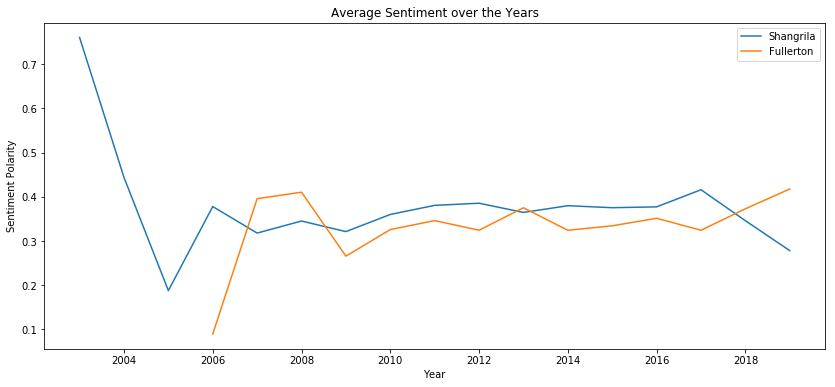

In [135]:
fig = plt.figure(figsize = (14,6))

for frame in [mean_breakfast_shang, mean_breakfast_fl]:
    plt.plot(frame['stay_year'], frame['sentiment'])
    
plt.legend(['Shangrila', 'Fullerton'])
plt.title('Average Sentiment over the Years')
plt.xlabel('Year')
plt.ylabel('Sentiment Polarity')
plt.show()

In [136]:
#x = mean_breakfast['stay_year']
#y = mean_breakfast['sentiment']
#z = mean_breakfast['rate']
#plt.figure(figsize = (14,5))
#plt.plot(x, y)
#plt.xticks(x)
#plt.title('Average Sentiment for Breakfast over the Years')
#plt.xlabel('Year')
#plt.ylabel('Sentiment Polarity')
#plt.show()

Sentiment has been generally positive and stable over the years. The dip in sentiment in 2019 is not reflective of the overall sentiment as data was collected in Jan 2019 where there is not yet enough review

#### Work on Sentiment for Bed

In [137]:
# work on breakfast sentiment
df_shang_TA4 = df_shang_TA.copy()
df_fl_TA4 = df_fl_TA.copy()

In [138]:
df_shang_TA4['bed'] = df_shang_TA4.apply(lambda x: get_key_sentence(x['review'], amenities['bed']), axis = 1)
df_fl_TA4['bed'] = df_fl_TA4.apply(lambda x: get_key_sentence(x['review'], amenities['bed']), axis = 1)

In [139]:
subset_bed_shang = df_shang_TA4.dropna(subset = ['bed'])
subset_bed_fl = df_fl_TA4.dropna(subset = ['bed'])

In [140]:
len(subset_bed_shang)

410

In [141]:
subset_bed_shang.reset_index(inplace = True)
subset_bed_fl.reset_index(inplace = True)

In [142]:
subset_bed_shang['sentiment'] = subset_bed_shang['bed'].apply(lambda x: TextBlob(x).sentiment.polarity)
subset_bed_fl['sentiment'] = subset_bed_fl['bed'].apply(lambda x: TextBlob(x).sentiment.polarity)

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [143]:
word_freq_bed_shang = parse_reviews(subset_bed_shang, 'bed')
word_freq_bed_fl = parse_reviews(subset_bed_fl, 'bed')

In [144]:
word_freq_bed_shang

{'loved': 9,
 'cubby': 1,
 'house': 4,
 'sleep': 24,
 'well': 42,
 'hidden': 1,
 'wall': 2,
 'complaint': 4,
 'personal': 1,
 'preference': 1,
 'thing': 7,
 'firm': 14,
 'spacious': 28,
 'comfortable': 130,
 'equipped': 5,
 'everything': 12,
 'need': 11,
 'including': 5,
 'foldaway': 1,
 'teenager': 1,
 'themed': 1,
 'bunk': 5,
 'writing': 2,
 'desk': 15,
 'letterbox': 1,
 'unlockable': 1,
 'treasure': 2,
 'chest': 1,
 'puzzle': 1,
 'carefully': 1,
 'explained': 1,
 'extra': 29,
 'sonour': 1,
 'free': 15,
 'breakfast': 35,
 'handed': 1,
 'card': 4,
 'brilliant': 4,
 'super': 5,
 'comfy': 24,
 'toiletry': 5,
 'quality': 12,
 'it’s': 3,
 'first': 16,
 'time': 23,
 'sgwhen': 1,
 'arrived': 11,
 'around': 6,
 'o’clock': 1,
 'didn’t': 5,
 'wait': 3,
 'roomfront': 1,
 'staff': 39,
 'greeted': 5,
 'reserve': 1,
 'welcome': 7,
 'drink': 15,
 'immediatelywe': 1,
 'deluxe': 8,
 'king': 44,
 'size': 36,
 'adorable': 1,
 'checked': 12,
 'asked': 10,
 'another': 6,
 'matter': 1,
 'said': 5,
 'okay'

In [145]:
word_freq_bed_fl

{'extremely': 7,
 'comfortable': 76,
 'good': 24,
 'quality': 15,
 'linen': 13,
 'clean': 17,
 'comfy': 9,
 'large': 13,
 'space': 4,
 'daughter': 2,
 'around': 5,
 'fantastic': 8,
 'night': 22,
 'sleep': 10,
 'unfortunately': 4,
 'also': 16,
 'problem': 2,
 'hard': 13,
 'worse': 1,
 'europejapan': 1,
 'took': 6,
 'hour': 6,
 'bring': 2,
 'thinnest': 1,
 'topper': 1,
 'i’ve': 1,
 'ever': 2,
 'seen': 3,
 'doubled': 1,
 'side': 5,
 'still': 4,
 'felt': 4,
 'like': 15,
 'sleeping': 4,
 'concrete': 1,
 'everything': 5,
 'damp': 2,
 'reasonthe': 1,
 'lighthouse': 3,
 'restaurant': 6,
 'terrace': 1,
 'place': 8,
 'view': 22,
 'marina': 8,
 'sand': 2,
 'laser': 1,
 'light': 5,
 'show': 1,
 'soft': 8,
 'small': 11,
 'called': 1,
 'brilliantly': 1,
 '“straits': 1,
 'suite”': 1,
 'king': 23,
 'bathroom': 28,
 'spacious': 14,
 'tiny': 3,
 'balcony': 5,
 'disappointment': 1,
 'every': 6,
 'stayed': 6,
 'facility': 3,
 'wonderful': 3,
 'inifinity': 1,
 'pool': 11,
 'lovely': 14,
 'area': 7,
 'swim'

In [146]:
# top 5 keywords
from collections import Counter
d_shang = Counter(word_freq_bed_shang)
phrase_words_shang = [x[0] for x in d_shang.most_common(5)] #find top 5 keywords describing each review
phrase_words_shang

['comfortable', 'wing', 'bathroom', 'large', 'king']

In [147]:
d_fl = Counter(word_freq_bed_fl)
phrase_words_fl = [x[0] for x in d_fl.most_common(5)] #find top 5 keywords describing each review
phrase_words_fl

['comfortable', 'bathroom', 'great', 'good', 'king']

In [148]:
# number of positive, negative, neutral review
print('Shangrila Sentiment count for Bed')
print('Positive Review: ' + str(len(subset_bed_shang[subset_bed_shang['sentiment'] > 0])))
print('Negative Review: ' + str(len(subset_bed_shang[subset_bed_shang['sentiment'] < 0])))
print('Neutral Review: ' + str(len(subset_bed_shang[subset_bed_shang['sentiment'] == 0])))

Shangrila Sentiment count for Bed
Positive Review: 321
Negative Review: 46
Neutral Review: 43


In [149]:
# number of positive, negative, neutral review
print('Fullerton Sentiment count for Bed')
print('Positive Review: ' + str(len(subset_bed_fl[subset_bed_fl['sentiment'] > 0])))
print('Negative Review: ' + str(len(subset_bed_fl[subset_bed_fl['sentiment'] < 0])))
print('Neutral Review: ' + str(len(subset_bed_fl[subset_bed_fl['sentiment'] == 0])))

Fullerton Sentiment count for Bed
Positive Review: 182
Negative Review: 35
Neutral Review: 21


In [150]:
print('3 highest sentiment review for Fullerton - Bed:')
print('')
for y in subset_bed_fl.nlargest(3, 'sentiment')['bed']:
    print(y)
    print('')
print('3 lowest sentiment review for Fullerton - Bed:')
print('')
for z in subset_bed_fl.nsmallest(3, 'sentiment')['bed']:
    print(z)
    print('')

3 highest sentiment review for Fullerton - Bed:

the service at the lounge was excellent, and you could choose the pillow you want.

The rooms overlooking the bay have the best views, stayed in room 677 and could lay in bed with the best views ever.

The bed was one of the best.

3 lowest sentiment review for Fullerton - Bed:

The bed was very hard and uncomfortable, although they were forthcoming with additional pillows when asked.

Even the curtains were dirtied and the bed cover had a small hole in it.We were too tired to bother requesting for a change of rooms at the end of the day.

I requested a King bed and it was really 2 singles pushed together - I HATE that.



In [151]:
print('3 highest sentiment review for Shangrila - Bed:')
print('')
for y in subset_bed_shang.nlargest(3, 'sentiment')['bed']:
    print(y)
    print('')
print('3 lowest sentiment review for Fullerton - Bed:')
print('')
for z in subset_bed_shang.nsmallest(3, 'sentiment')['bed']:
    print(z)
    print('')

3 highest sentiment review for Shangrila - Bed:

Courteous service,eager staff to help you & excellent breakfast,nice bed & good view- what else do you need as business traveller !

Even with a roll away bed there was plenty of room for two adults and a 9 yo to relax in comfort.Breakfast in the Valley Wing was a wonderful experience with waiter service and an amazing range of food and beverage selections.

The bed was comfortable.The pool area is very nice indeed.

3 lowest sentiment review for Fullerton - Bed:

The room was freezing cold and the duvet was really pathetic and disgraceful for a 5 star hotel.

I booked a king size and was provided twin bed room - a bit of a disappointment.

Unfortunately the bed was on wheels and unable to lock.



In [152]:
#subset_bed['stay_year'] = subset_bed.stay_date.apply(lambda x: x.strftime('%y'))

In [153]:
# the review in 2019 pertaining to mattress
for i in subset_bed_shang['bed'][subset_bed_shang['stay_year'] == 2019]:
    print(i)

The kids loved the cubby house to sleep in, as well as the hidden bed in the wall.
The only complaint - and this is a personal preference thing - is that the mattress was a bit too firm.


In [154]:
mean_bed_shang = subset_bed_shang.groupby('stay_year').mean().reset_index()
mean_bed_fl = subset_bed_fl.groupby('stay_year').mean().reset_index()

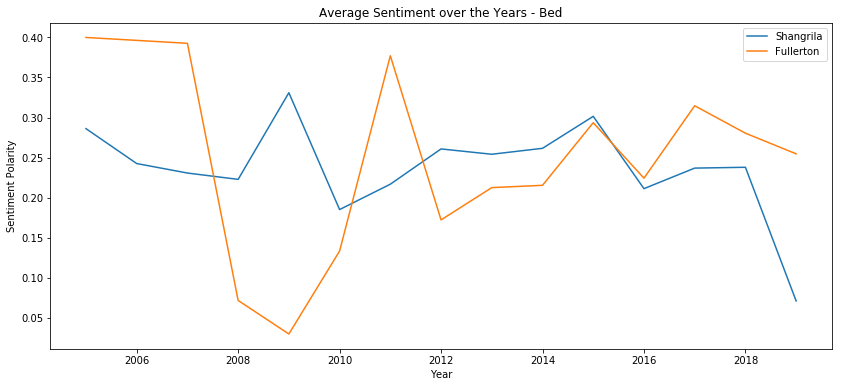

In [155]:
fig = plt.figure(figsize = (14,6))

for frame in [mean_bed_shang, mean_bed_fl]:
    plt.plot(frame['stay_year'], frame['sentiment'])
    
plt.legend(['Shangrila', 'Fullerton'])
plt.title('Average Sentiment over the Years - Bed')
plt.xlabel('Year')
plt.ylabel('Sentiment Polarity')
plt.show()

In [156]:
#x = mean_bed['stay_year']
#y = mean_bed['sentiment']
#z = mean_breakfast['rate']
#plt.figure(figsize = (14,5))
#plt.plot(x, y)
#plt.xticks(x)
#plt.title('Average Sentiment for Bed over the Years')
#plt.xlabel('Year')
#plt.ylabel('Sentiment Polarity')
#plt.show()

In general Shangrila has better sentiment polarity for bed than Fullerton although in the last 3 years Fullerton has been better than Shangrila.

In [157]:
# work on noise sentiment
df_shang_TA5 = df_shang_TA.copy()
df_fl_TA5 = df_fl_TA.copy()

In [158]:
df_shang_TA5['noise'] = df_shang_TA5.apply(lambda x: get_key_sentence(x['review'], amenities['noise']), axis = 1)
df_fl_TA5['noise'] = df_fl_TA5.apply(lambda x: get_key_sentence(x['review'], amenities['noise']), axis = 1)

In [159]:
subset_noise_shang = df_shang_TA5.dropna(subset = ['noise'])
subset_noise_fl = df_fl_TA5.dropna(subset = ['noise'])

In [160]:
subset_noise_shang.reset_index(inplace = True)
subset_noise_fl.reset_index(inplace = True)
subset_noise_shang['sentiment'] = subset_noise_shang['noise'].apply(lambda x: TextBlob(x).sentiment.polarity)
subset_noise_fl['sentiment'] = subset_noise_fl['noise'].apply(lambda x: TextBlob(x).sentiment.polarity)

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [161]:
word_freq_noise_shang = parse_reviews(subset_noise_shang, 'noise')
d_shang = Counter(word_freq_noise_shang)
phrase_words_shang = [x[0] for x in d_shang.most_common(5)] #find top 3 keywords describing each review
print('Most Frequent Words in Shangrila Review on Noise')
print(phrase_words_shang)

Most Frequent Words in Shangrila Review on Noise
['area', 'orchard', 'road', 'wing', 'breakfast']


In [162]:
word_freq_noise_fl = parse_reviews(subset_noise_fl, 'noise')
d_fl = Counter(word_freq_noise_fl)
phrase_words_fl = [x[0] for x in d_fl.most_common(5)] #find top 3 keywords describing each review
print('Most Frequent Words in Fullerton Review on Noise')
print(phrase_words_fl)

Most Frequent Words in Fullerton Review on Noise
['night', 'view', 'stay', 'breakfast', 'staff']


In [163]:
# number of positive, negative, neutral review
print('Number of Positive, Negative, Neutral Review in terms of noise for Shangrila')
print('Positive Review: ' + str(len(subset_noise_shang[subset_noise_shang['sentiment'] > 0])))
print('Negative Review: ' + str(len(subset_noise_shang[subset_noise_shang['sentiment'] < 0])))
print('Neutral Review: ' + str(len(subset_noise_shang[subset_noise_shang['sentiment'] == 0])))

Number of Positive, Negative, Neutral Review in terms of noise for Shangrila
Positive Review: 273
Negative Review: 35
Neutral Review: 46


In [164]:
print('Top 3 positive sentiment regarding noise - Shangrila')
print('')
for x in subset_noise_shang.nlargest(3, 'sentiment')['noise']:
    print(x)
    print('')

print('top 3 negative sentiment regarding noise - Shangrila')
print('')
for z in subset_noise_shang.nsmallest(3, 'sentiment')['noise']:
    print(z)
    print('')

Top 3 positive sentiment regarding noise - Shangrila

Breakfast was delicious in the line restaurantDespite the works in the Tower wing, no issues with noise or whatever, everything went perfect.

Or you should wear a noise reducer helmet!All in one: very pleasant stay, wonderful hotel.

In the meantime drilling noise makes for lack of serenity in an otherwise beautiful garden and pool area.

top 3 negative sentiment regarding noise - Shangrila

Worse thing, people make a terrible noise on phone talking publicly.

They were doing renovations on the pool during my stay which was a little disappointing because the pool was just a noisy area.

We were quiet shocked infact, we didn’t feel that we were in a shangrla.



In [165]:
print('Top 3 positive sentiment regarding noise - Fullerton')
print('')
for x in subset_noise_fl.nlargest(3, 'sentiment')['noise']:
    print(x)
    print('')

print('top 3 negative sentiment regarding noise - Fullerton')
print('')
for z in subset_noise_fl.nsmallest(3, 'sentiment')['noise']:
    print(z)
    print('')

Top 3 positive sentiment regarding noise - Fullerton

This hotel does not have any discos or bars which may attract noisy audiences from outside.The rooms are meticulously attended, and you always get the best sleeping environments.

There was no noise whatsoever, and I did not hear any neighbors talking, etc.Food: The BEST breakfast buffet I've ever seen in many years of travel.

The pool was also great, it is quiet but perfect.

top 3 negative sentiment regarding noise - Fullerton

Considering our upgraded room was plugged as one of the hotel's finest rooms, I was disappointed to find it was an adjoining room, with a shabby door that did nothing to soften the noise created by the noisiest neighbour I have ever had the misfortune of enduring.

There is piped music seemingly everywhere which is too loud and very irritating .....especially around the pool where you just feel like pulling the wires out of the speakers.!!!

The bad, the room I stayed in had a really annoying noise coming 

In [166]:
#subset_noise['stay_year'] = subset_noise.stay_date.apply(lambda x: x.strftime('%y'))

In [167]:
for i in subset_noise_shang['noise'][subset_noise_shang['stay_year'] == 2018]:
    print (i)
    print ('')

The Valley Wing is quiet and beautiful, staff were fab and the free 'British' tea and drinks was really nice.

The Horizon Club staff were professional and helpful, however the club lounge itself didn’t seem cosy or particularly comfortable with hardly any soft seating with the area given over to canteen style tables and chairs, with a very noisy kids section at one end.

First, the location of the hotel is short distance from the noise and sounds of the bustling city.

It's ideally situated slightly away from the bustle of the main Orchard Road shopping centres (although is a five minute walk away from the Northern end of Orchard Road) and is in a quiet largely residential area, close to the Botanic Gardens.

The rooms at the garden wing have a nice balcony that overlooks the pool and makes for a nice quiet drinking spot in the evening.

The location is very near the shopping area but so quiet as if you are not in the city.

it has a glass cabinet that u can see all your clothes, it w

In [168]:
mean_noise_shang = subset_noise_shang.groupby('stay_year').mean().reset_index()
mean_noise_fl = subset_noise_fl.groupby('stay_year').mean().reset_index()

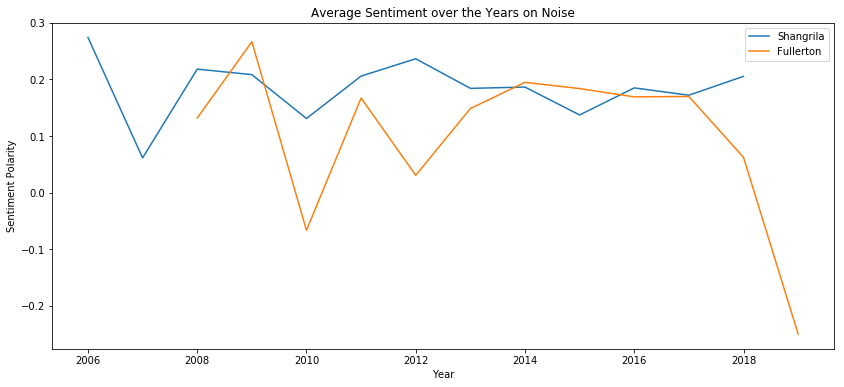

In [169]:
fig = plt.figure(figsize = (14,6))

for frame in [mean_noise_shang, mean_noise_fl]:
    plt.plot(frame['stay_year'], frame['sentiment'])
    
plt.legend(['Shangrila', 'Fullerton'])
plt.title('Average Sentiment over the Years on Noise')
plt.xlabel('Year')
plt.ylabel('Sentiment Polarity')
plt.show()

In [170]:
#x = mean_noise['stay_year']
#y = mean_noise['sentiment']
#z = mean_breakfast['rate']
#plt.figure(figsize = (14,5))
#plt.plot(x, y)
#plt.xticks(x)
#plt.title('Average Sentiment for Noise over the Years')
#plt.xlabel('Year')
#plt.ylabel('Sentiment Polarity')
#plt.show()

### 5. Feature Generation using TF IDF

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [172]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.9)
review_tfidf_shang = vectorizer.fit_transform(df_shang_TA['tokenized_review'])
review_tfidf_fl = vectorizer.transform(df_fl_TA['tokenized_review'])

In [173]:
df_shang_TA_tdidf = pd.DataFrame(review_tfidf_shang.todense(), columns=vectorizer.get_feature_names())
len(df_shang_TA_tdidf)

4531

In [174]:
df_shang_TA_tdidf.iloc[5:10,1:20]

,100,1000,1015,1030,1030am,1030pm,10am,10min,10mins,10pm,10th,11,1100,11am,11pm,11th,12,12th,13
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Split Training and Test Data

In [175]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(
    #text_counts, data['Sentiment'], test_size=0.3, random_state=1)

In [176]:
df_shang_TA.head(3)

,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat
0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,minute greeted staff outside quite uniform esc...,1
1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1
2,Fantastic stay,The hotel is stunning and has so much to offer...,2019-01-01,2019-01-20,NaN,5,couple,NaN,2019.0,stunning much offer couple family gym especial...,1


In [177]:
df_shang_TA.reset_index()

,index,title,review,stay_date,review_date,origin,rate,trip_type,detail_rate,stay_year,tokenized_review,rate_cat
0,0,One of the best!,The minute you are greeted by the staff outsid...,2019-01-01,2019-01-20,"Chicago, Illinois",5,couple,"Location, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,minute greeted staff outside quite uniform esc...,1
1,1,What an experience!!,The Valley wing was absolutely fabulous. From ...,2018-07-01,2018-08-05,Main Beach,5,couple,"Sleep Quality, 5.0, Rooms, 5.0, Service, 5.0",2018.0,valley wing absolutely fabulous moment checked...,1
2,2,Fantastic stay,The hotel is stunning and has so much to offer...,2019-01-01,2019-01-20,NaN,5,couple,NaN,2019.0,stunning much offer couple family gym especial...,1
3,3,You’re simply the best!,"Arriving for a two days stop over, playing gol...",2019-01-01,2019-01-19,"Shanghai, China",5,solo,NaN,2019.0,arriving two day stop playing golf unfortunate...,1
4,4,Vacation,Lovely pool with lush garden griunds and atten...,2019-01-01,2019-01-17,NaN,5,couple,NaN,2019.0,lovely pool lush garden griunds attentive staf...,1
5,7,Family stay in the Treetop Family Suite,We just had a fantastic two night stay in the ...,2019-01-01,2019-01-17,"Singapore River, Singapore",5,family,NaN,2019.0,fantastic two night stay treetop family themed...,1
6,8,Exactly what you'd expect from a Shangri-La,Definitely one of my favourite brands and the ...,2019-01-01,2019-01-16,"Vancouver, Canada",5,couple,"Value, 4.0, Cleanliness, 5.0, Service, 5.0",2019.0,definitely one favourite brand original starte...,1
7,9,Absolute excellence in every respect,The foyer was bedecked with stunning Christmas...,2018-12-01,2019-01-16,"Brisbane, Australia",5,solo,"Location, 5.0, Rooms, 5.0, Service, 5.0",2018.0,foyer bedecked stunning christmas decoration s...,1
8,10,Excellent service,The service in this hotel is always exceptiona...,2019-01-01,2019-01-16,"Kuala Lumpur, Malaysia",5,business,NaN,2019.0,service always exceptional special mention man...,1
9,11,Simply Perfect,"By far one of the best hotels we’ve stayed in,...",2018-12-01,2019-01-15,"Sydney, Australia",5,family,NaN,2018.0,far one best we’ve stayed booked deluxe family...,1


In [178]:
#review_tfidf = vectorizer.fit_transform(df_shang_TA['tokenized_review'])

In [179]:
# Set the y for Shangrila data
y = df_shang_TA['rate_cat']
len(y)

4531

In [192]:
# Set the y for Fullerton Data
y_fl = df_fl_TA['rate_cat']

In [193]:
# Split Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    review_tfidf_shang, y, test_size=0.2, random_state=123)

In [194]:
# From Train further split to Train1 and Validation
X_train1, X_val, y_train1, y_val = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 123)

Apply TFIDF with Logistic Regression

In [195]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

In [197]:
from sklearn import metrics
from sklearn.metrics import classification_report

Logistic Regression

In [198]:
# without Rebalancing
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression().fit(X_train1, y_train1)
pred_LogReg = LogReg.predict(X_val)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_val, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_val, pred_LogReg, average = 'weighted'))
print(classification_report(y_val, pred_LogReg))

Logistic Regression Accuracy: 0.9006896551724138
Logisctic Regression F1 score: 0.8536289475001251
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        31
           0       0.00      0.00      0.00        41
           1       0.90      1.00      0.95       653

   micro avg       0.90      0.90      0.90       725
   macro avg       0.30      0.33      0.32       725
weighted avg       0.81      0.90      0.85       725



In [199]:
pred_LogReg = LogReg.predict(X_test)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_test, pred_LogReg, average = 'weighted'))
print(classification_report(y_test, pred_LogReg))

Logistic Regression Accuracy: 0.9173098125689085
Logisctic Regression F1 score: 0.8777478597554134
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        33
           0       0.00      0.00      0.00        42
           1       0.92      1.00      0.96       832

   micro avg       0.92      0.92      0.92       907
   macro avg       0.31      0.33      0.32       907
weighted avg       0.84      0.92      0.88       907



- Deal with imbalanced data
- SMOTE (Synthetic Minority Over-Sampling Technique)
- SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.

In [200]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(X_train1, y_train1)
#pd.DataFrame(X_SMOTE.todense())

In [201]:
X_SMOTE.shape[0]

7962

In [202]:
# Logistic Regression with Rebalanced Data
LogReg = LogisticRegression().fit(X_SMOTE, y_SMOTE)
pred_LogReg = LogReg.predict(X_val)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_val, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_val, pred_LogReg, average = 'weighted'))
print(classification_report(y_val, pred_LogReg))

Logistic Regression Accuracy: 0.9062068965517242
Logisctic Regression F1 score: 0.9069589701224332
              precision    recall  f1-score   support

          -1       0.72      0.42      0.53        31
           0       0.36      0.46      0.40        41
           1       0.96      0.96      0.96       653

   micro avg       0.91      0.91      0.91       725
   macro avg       0.68      0.61      0.63       725
weighted avg       0.91      0.91      0.91       725



In [203]:
# logistic Regression with rebalanced Data on the test Data
pred_LogReg = LogReg.predict(X_test)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_test, pred_LogReg, average = 'weighted'))
print(classification_report(y_test, pred_LogReg))

Logistic Regression Accuracy: 0.9217199558985667
Logisctic Regression F1 score: 0.9222320942567461
              precision    recall  f1-score   support

          -1       0.50      0.36      0.42        33
           0       0.35      0.43      0.38        42
           1       0.97      0.97      0.97       832

   micro avg       0.92      0.92      0.92       907
   macro avg       0.61      0.59      0.59       907
weighted avg       0.92      0.92      0.92       907



In [204]:
# using Logistic Regression to predict Fullerton hotel data
pred_LogReg = LogReg.predict(review_tfidf_fl)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_fl, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_fl, pred_LogReg, average = 'weighted'))
print(classification_report(y_fl, pred_LogReg))

Logistic Regression Accuracy: 0.8670520231213873
Logisctic Regression F1 score: 0.8716840166324421
              precision    recall  f1-score   support

          -1       0.44      0.48      0.46       102
           0       0.40      0.46      0.43       181
           1       0.95      0.93      0.94      1793

   micro avg       0.87      0.87      0.87      2076
   macro avg       0.60      0.62      0.61      2076
weighted avg       0.88      0.87      0.87      2076



SVM

In [205]:
from sklearn.svm import SVC
clf = SVC(gamma = 'auto', random_state = 123)
SVM = clf.fit(X_SMOTE, y_SMOTE)
pred_SVM = SVM.predict(X_val)
print("SVM Accuracy:", metrics.accuracy_score(y_val, pred_SVM))
print("SVM F1 score:", metrics.f1_score(y_val, pred_SVM, average = 'weighted'))
print(classification_report(y_val, pred_SVM))

SVM Accuracy: 0.9048275862068965
SVM F1 score: 0.8912262037412291
              precision    recall  f1-score   support

          -1       0.80      0.13      0.22        31
           0       0.35      0.34      0.35        41
           1       0.94      0.98      0.96       653

   micro avg       0.90      0.90      0.90       725
   macro avg       0.70      0.48      0.51       725
weighted avg       0.90      0.90      0.89       725



In [206]:
pred_SVM = SVM.predict(X_test)
print("SVM Accuracy:", metrics.accuracy_score(y_test, pred_SVM))
print("SVM F1 score:", metrics.f1_score(y_test, pred_SVM, average = 'weighted'))
print(classification_report(y_test, pred_SVM))

SVM Accuracy: 0.9195148842337376
SVM F1 score: 0.9099751634209844
              precision    recall  f1-score   support

          -1       0.20      0.06      0.09        33
           0       0.38      0.43      0.40        42
           1       0.96      0.98      0.97       832

   micro avg       0.92      0.92      0.92       907
   macro avg       0.51      0.49      0.49       907
weighted avg       0.90      0.92      0.91       907



In [207]:
# Try predicting sentiment in Fullerton hotel data

y_fl = df_fl_TA['rate_cat']
pred_SVM = SVM.predict(review_tfidf_fl)
print("SVM Accuracy:", metrics.accuracy_score(y_fl, pred_SVM))
print("SVM F1 score:", metrics.f1_score(y_fl, pred_SVM, average = 'weighted'))
print(classification_report(y_fl, pred_SVM))

SVM Accuracy: 0.8790944123314065
SVM F1 score: 0.869157055967155
              precision    recall  f1-score   support

          -1       0.61      0.25      0.35       102
           0       0.41      0.39      0.40       181
           1       0.93      0.96      0.95      1793

   micro avg       0.88      0.88      0.88      2076
   macro avg       0.65      0.53      0.57      2076
weighted avg       0.87      0.88      0.87      2076



Multinomial Naive Bayes

In [208]:
# without rebalancing
from sklearn.naive_bayes import MultinomialNB
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train1, y_train1)
predicted= clf.predict(X_val)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_val, predicted))
print(classification_report(y_val, predicted))

MultinomialNB Accuracy: 0.9006896551724138
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        31
           0       0.00      0.00      0.00        41
           1       0.90      1.00      0.95       653

   micro avg       0.90      0.90      0.90       725
   macro avg       0.30      0.33      0.32       725
weighted avg       0.81      0.90      0.85       725



C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [209]:
predicted_test = clf.predict(X_test)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_test, predicted_test))
print("MultinomialNB F1 score:", metrics.f1_score(y_test, predicted_test, average = 'weighted'))
print(classification_report(y_test, predicted_test))

MultinomialNB Accuracy:  0.9173098125689085
MultinomialNB F1 score: 0.8777478597554134
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        33
           0       0.00      0.00      0.00        42
           1       0.92      1.00      0.96       832

   micro avg       0.92      0.92      0.92       907
   macro avg       0.31      0.33      0.32       907
weighted avg       0.84      0.92      0.88       907



C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [210]:
# with rebalancing
from sklearn.naive_bayes import MultinomialNB
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_SMOTE, y_SMOTE)
predicted= clf.predict(X_val)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_val, predicted))
print(classification_report(y_val, predicted))

MultinomialNB Accuracy: 0.9048275862068965
              precision    recall  f1-score   support

          -1       0.59      0.32      0.42        31
           0       0.38      0.68      0.49        41
           1       0.97      0.95      0.96       653

   micro avg       0.90      0.90      0.90       725
   macro avg       0.65      0.65      0.62       725
weighted avg       0.92      0.90      0.91       725



In [211]:
predicted_test = clf.predict(X_test)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_test, predicted_test))
print("MultinomialNB F1 score:", metrics.f1_score(y_test, predicted_test, average = 'weighted'))
print(classification_report(y_test, predicted_test))

MultinomialNB Accuracy:  0.8996692392502756
MultinomialNB F1 score: 0.9082452358501234
              precision    recall  f1-score   support

          -1       0.38      0.30      0.34        33
           0       0.29      0.52      0.37        42
           1       0.97      0.94      0.96       832

   micro avg       0.90      0.90      0.90       907
   macro avg       0.55      0.59      0.56       907
weighted avg       0.92      0.90      0.91       907



In [212]:
# using Multinomial Naive bayes to predict Fullerton hotel data

predicted_test = clf.predict(review_tfidf_fl)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_fl, predicted_test))
print("MultinomialNB F1 score:", metrics.f1_score(y_fl, predicted_test, average = 'weighted'))
print(classification_report(y_fl, predicted_test))

MultinomialNB Accuracy:  0.8376685934489403
MultinomialNB F1 score: 0.8544438492779807
              precision    recall  f1-score   support

          -1       0.33      0.45      0.38       102
           0       0.34      0.52      0.41       181
           1       0.96      0.89      0.93      1793

   micro avg       0.84      0.84      0.84      2076
   macro avg       0.54      0.62      0.57      2076
weighted avg       0.88      0.84      0.85      2076



GridSearchCV to find optimal parameters for each model

In [224]:
# Grid Search CV on Logistic Regression 
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv = 5)
#GridSearchCV(cv=5,
             #estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               #dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             #param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
clf.fit(X_SMOTE, y_SMOTE)

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [222]:
clf.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [223]:
clf.best_params_

{'C': 1000}

In [231]:
LogReg = LogisticRegression(C = 1000).fit(X_SMOTE, y_SMOTE)
pred_LogReg = LogReg.predict(X_val)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_val, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_val, pred_LogReg, average = 'weighted'))
print(classification_report(y_val, pred_LogReg))

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression Accuracy: 0.9117241379310345
Logisctic Regression F1 score: 0.899518433160915
              precision    recall  f1-score   support

          -1       0.67      0.19      0.30        31
           0       0.46      0.39      0.42        41
           1       0.94      0.98      0.96       653

   micro avg       0.91      0.91      0.91       725
   macro avg       0.69      0.52      0.56       725
weighted avg       0.90      0.91      0.90       725



In [232]:
# logistic Regression with rebalanced Data on the test Data
pred_LogReg = LogReg.predict(X_test)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_test, pred_LogReg, average = 'weighted'))
print(classification_report(y_test, pred_LogReg))

Logistic Regression Accuracy: 0.9327453142227122
Logisctic Regression F1 score: 0.9235363909030897
              precision    recall  f1-score   support

          -1       0.60      0.27      0.37        33
           0       0.44      0.33      0.38        42
           1       0.96      0.99      0.97       832

   micro avg       0.93      0.93      0.93       907
   macro avg       0.66      0.53      0.58       907
weighted avg       0.92      0.93      0.92       907



In [233]:
# using Logistic Regression to predict Fullerton hotel data
pred_LogReg = LogReg.predict(review_tfidf_fl)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_fl, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_fl, pred_LogReg, average = 'weighted'))
print(classification_report(y_fl, pred_LogReg))

Logistic Regression Accuracy: 0.8805394990366089
Logisctic Regression F1 score: 0.8705728172182566
              precision    recall  f1-score   support

          -1       0.51      0.34      0.41       102
           0       0.44      0.34      0.38       181
           1       0.93      0.97      0.95      1793

   micro avg       0.88      0.88      0.88      2076
   macro avg       0.63      0.55      0.58      2076
weighted avg       0.86      0.88      0.87      2076



In [227]:
# Grid Search CV on SVM
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(SVC(gamma = 'auto', random_state = 123), param_grid, cv = 5)
#GridSearchCV(cv=5,
             #estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               #dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             #param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
clf.fit(X_SMOTE, y_SMOTE)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [228]:
clf.best_estimator_

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

In [229]:
clf.best_params_

{'C': 1000}

In [234]:
# SVM
from sklearn.svm import SVC
clf = SVC(C = 1000, gamma = 'auto', random_state = 123)
SVM = clf.fit(X_SMOTE, y_SMOTE)
pred_SVM = SVM.predict(X_val)
print("SVM Accuracy:", metrics.accuracy_score(y_val, pred_SVM))
print("SVM F1 score:", metrics.f1_score(y_val, pred_SVM, average = 'weighted'))
print(classification_report(y_val, pred_SVM))

SVM Accuracy: 0.9075862068965517
SVM F1 score: 0.9007350631674989
              precision    recall  f1-score   support

          -1       0.58      0.23      0.33        31
           0       0.42      0.46      0.44        41
           1       0.95      0.97      0.96       653

   micro avg       0.91      0.91      0.91       725
   macro avg       0.65      0.55      0.57       725
weighted avg       0.90      0.91      0.90       725



In [235]:
pred_SVM = SVM.predict(X_test)
print("SVM Accuracy:", metrics.accuracy_score(y_test, pred_SVM))
print("SVM F1 score:", metrics.f1_score(y_test, pred_SVM, average = 'weighted'))
print(classification_report(y_test, pred_SVM))

SVM Accuracy: 0.9283351708930541
SVM F1 score: 0.91992043986545
              precision    recall  f1-score   support

          -1       0.59      0.30      0.40        33
           0       0.33      0.26      0.29        42
           1       0.96      0.99      0.97       832

   micro avg       0.93      0.93      0.93       907
   macro avg       0.63      0.52      0.56       907
weighted avg       0.92      0.93      0.92       907



In [236]:
# Try predicting sentiment in Fullerton hotel data

y_fl = df_fl_TA['rate_cat']
pred_SVM = SVM.predict(review_tfidf_fl)
print("SVM Accuracy:", metrics.accuracy_score(y_fl, pred_SVM))
print("SVM F1 score:", metrics.f1_score(y_fl, pred_SVM, average = 'weighted'))
print(classification_report(y_fl, pred_SVM))

SVM Accuracy: 0.8631984585741811
SVM F1 score: 0.8624712018779219
              precision    recall  f1-score   support

          -1       0.55      0.32      0.41       102
           0       0.36      0.43      0.39       181
           1       0.93      0.94      0.94      1793

   micro avg       0.86      0.86      0.86      2076
   macro avg       0.61      0.56      0.58      2076
weighted avg       0.87      0.86      0.86      2076



In [237]:
# Grid Search CV on Multinomial NB
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.5, 1, 1.5, 2, 2.5, 3, 3.5] }
clf = GridSearchCV(MultinomialNB(), param_grid, cv = 5)
#GridSearchCV(cv=5,
             #estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               #dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             #param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
clf.fit(X_SMOTE, y_SMOTE)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.5, 1, 1.5, 2, 2.5, 3, 3.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [238]:
clf.best_estimator_

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [239]:
clf.best_params_

{'alpha': 0.5}

In [240]:
from sklearn.naive_bayes import MultinomialNB
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB(alpha = 0.5).fit(X_SMOTE, y_SMOTE)
predicted= clf.predict(X_val)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_val, predicted))
print(classification_report(y_val, predicted))

MultinomialNB Accuracy: 0.9006896551724138
              precision    recall  f1-score   support

          -1       0.50      0.23      0.31        31
           0       0.37      0.61      0.46        41
           1       0.96      0.95      0.96       653

   micro avg       0.90      0.90      0.90       725
   macro avg       0.61      0.60      0.58       725
weighted avg       0.91      0.90      0.90       725



In [241]:
predicted_test = clf.predict(X_test)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_test, predicted_test))
print("MultinomialNB F1 score:", metrics.f1_score(y_test, predicted_test, average = 'weighted'))
print(classification_report(y_test, predicted_test))

MultinomialNB Accuracy:  0.9018743109151047
MultinomialNB F1 score: 0.9056252572468668
              precision    recall  f1-score   support

          -1       0.30      0.21      0.25        33
           0       0.29      0.45      0.36        42
           1       0.97      0.95      0.96       832

   micro avg       0.90      0.90      0.90       907
   macro avg       0.52      0.54      0.52       907
weighted avg       0.91      0.90      0.91       907



In [242]:
# using Multinomial Naive bayes to predict Fullerton hotel data

predicted_test = clf.predict(review_tfidf_fl)
print("MultinomialNB Accuracy: ", metrics.accuracy_score(y_fl, predicted_test))
print("MultinomialNB F1 score:", metrics.f1_score(y_fl, predicted_test, average = 'weighted'))
print(classification_report(y_fl, predicted_test))

MultinomialNB Accuracy:  0.853082851637765
MultinomialNB F1 score: 0.8606724847760737
              precision    recall  f1-score   support

          -1       0.38      0.44      0.41       102
           0       0.36      0.44      0.40       181
           1       0.95      0.92      0.93      1793

   micro avg       0.85      0.85      0.85      2076
   macro avg       0.56      0.60      0.58      2076
weighted avg       0.87      0.85      0.86      2076



TFIDF with Logistic Regression works best

We re-train the model using the whole of Shangrila data and use Fullerton hotel data as prediction

In [245]:
LogReg = LogisticRegression(C = 1000).fit(review_tfidf_shang, y)
pred_LogReg = LogReg.predict(review_tfidf_fl)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_fl, pred_LogReg))
print("Logisctic Regression F1 score:", metrics.f1_score(y_fl, pred_LogReg, average = 'weighted'))
print(classification_report(y_fl, pred_LogReg))

C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nchandra.CATLIN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression Accuracy: 0.8819845857418112
Logisctic Regression F1 score: 0.8603509779961248
              precision    recall  f1-score   support

          -1       0.52      0.26      0.35       102
           0       0.43      0.22      0.29       181
           1       0.91      0.98      0.95      1793

   micro avg       0.88      0.88      0.88      2076
   macro avg       0.62      0.49      0.53      2076
weighted avg       0.85      0.88      0.86      2076

